
# Exploratory Data Analysis (EDA)
## Long-Term Climate Analysis: Madrid (ERA5)

Celem niniejszej analizy jest eksploracyjna ocena
długoterminowych zmian klimatu w regionie Madrytu
na podstawie danych reanalizy ERA5 (1994–2024).

Analiza ma charakter deskryptywny i diagnostyczny
i stanowi podstawę do dalszych wniosków
oraz potencjalnego modelowania predykcyjnego.


## 1. Wczytanie danych i wstępna kontrola jakości

### 📌 Kod



In [27]:
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [28]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


files = Path("../clean_data").glob("*.parquet")

df = pd.concat(
    (pd.read_parquet(f) for f in files),
    ignore_index=True
)

df.head(5)



,latitude,longitude,t2m_mean,t2m_max,t2m_min,d2m_mean,skt_mean,sp_mean,blh_mean,tcc_mean,soil_moisture,tp_sum,e_sum,ssrd_sum,date,hour,year,month,day,dayofyear,season,lai_total,ws_mean
0,38.5,-6.0,10.289764,11.458893,9.736481,9.086151,10.105072,97126.875000,434.331635,0.994072,0.293809,0.046730,-0.010526,134144.0,1994-01-01,0,1994,1,1,1,1,3.939392,2.813566
1,38.5,-6.0,11.305145,13.904694,8.105377,7.514069,11.303131,97150.828125,462.986633,0.601974,0.291006,0.000477,-0.171009,2261120.0,1994-01-01,12,1994,1,1,1,1,3.940826,2.670740
2,38.5,-6.0,7.491089,8.396759,6.777008,6.499939,6.366913,97018.609375,52.482376,0.839874,0.290871,0.006199,0.005607,210752.0,1994-01-02,0,1994,1,2,2,1,3.942078,1.328706
3,38.5,-6.0,11.852875,13.744049,9.142242,8.012268,11.847626,96761.234375,453.875336,0.960083,0.288873,0.005722,-0.164966,1872832.0,1994-01-02,12,1994,1,2,2,1,3.943573,1.811240
4,38.5,-6.0,9.341919,10.152496,8.252472,7.491516,8.068237,96438.406250,140.091217,0.609650,0.288914,0.008583,0.004828,222784.0,1994-01-03,0,1994,1,3,3,1,3.944946,2.070344


# Zobaczenie struktury plików

In [29]:
df['date'] = pd.to_datetime(df['date'])
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7538497 entries, 0 to 7538496
Data columns (total 23 columns):
 #   Column         Dtype         
---  ------         -----         
 0   latitude       float64       
 1   longitude      float64       
 2   t2m_mean       float32       
 3   t2m_max        float32       
 4   t2m_min        float32       
 5   d2m_mean       float32       
 6   skt_mean       float32       
 7   sp_mean        float32       
 8   blh_mean       float32       
 9   tcc_mean       float32       
 10  soil_moisture  float32       
 11  tp_sum         float32       
 12  e_sum          float32       
 13  ssrd_sum       float32       
 14  date           datetime64[ns]
 15  hour           int8          
 16  year           int16         
 17  month          int8          
 18  day            int8          
 19  dayofyear      int16         
 20  season         int8          
 21  lai_total      float32       
 22  ws_mean        float32       
dtypes: date

,latitude,longitude,t2m_mean,t2m_max,t2m_min,d2m_mean,skt_mean,sp_mean,blh_mean,tcc_mean,soil_moisture,tp_sum,e_sum,ssrd_sum,date,hour,year,month,day,dayofyear,season,lai_total,ws_mean
count,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7538497.00,7538497,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06,7.538497e+06
mean,4.050000e+01,-3.750000e+00,1.375712e+01,1.629041e+01,1.112144e+01,5.736118e+00,1.402160e+01,9.230927e+04,6.643989e+02,4.677610e-01,2.389698e-01,2.550417e-01,-2.081232e-01,2825078.75,2009-12-22 06:00:00.925490432,5.999743e+00,2.009476e+03,6.514247e+00,1.571931e+01,1.828508e+02,2.505463e+00,3.947492e+00,2.648200e+00
min,3.850000e+01,-6.000000e+00,-1.773248e+01,-1.617831e+01,-2.017725e+01,-2.878140e+01,-2.158101e+01,8.247389e+04,9.965368e+00,0.000000e+00,-4.196581e-03,0.000000e+00,-1.738644e+00,0.00,1994-01-01 00:00:00,0.000000e+00,1.994000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.400665e+00,1.481360e-03
25%,3.950000e+01,-5.000000e+00,7.492889e+00,9.436188e+00,5.495270e+00,2.454376e+00,6.734955e+00,9.060700e+04,2.410385e+02,1.088486e-01,1.494177e-01,0.000000e+00,-2.854369e-01,1040448.00,2001-12-27 00:00:00,0.000000e+00,2.001000e+03,4.000000e+00,8.000000e+00,9.200000e+01,2.000000e+00,3.657593e+00,1.512087e+00
50%,4.050000e+01,-3.750000e+00,1.279501e+01,1.542496e+01,1.041739e+01,6.098358e+00,1.267935e+01,9.241308e+04,5.116001e+02,4.634705e-01,2.403646e-01,0.000000e+00,-1.442349e-01,2144768.00,2009-12-22 00:00:00,0.000000e+00,2.009000e+03,7.000000e+00,1.600000e+01,1.830000e+02,3.000000e+00,3.861755e+00,2.333964e+00
75%,4.150000e+01,-2.500000e+00,1.952106e+01,2.288492e+01,1.633365e+01,9.370209e+00,2.042972e+01,9.390662e+04,9.818538e+02,7.983398e-01,3.222969e-01,8.153915e-02,-5.313894e-02,4415168.00,2017-12-18 00:00:00,1.200000e+01,2.017000e+03,1.000000e+01,2.300000e+01,2.740000e+02,3.000000e+00,4.265503e+00,3.517678e+00
max,4.250000e+01,-1.500000e+00,4.128946e+01,4.452750e+01,3.758072e+01,2.185336e+01,4.588663e+01,1.003075e+05,3.793989e+03,1.000000e+00,5.109309e-01,3.288698e+01,3.468150e-01,8346496.00,2025-12-13 00:00:00,1.200000e+01,2.025000e+03,1.200000e+01,3.100000e+01,3.660000e+02,4.000000e+00,5.481689e+00,1.354334e+01
std,1.224745e+00,1.369306e+00,8.309739e+00,8.857915e+00,7.503702e+00,4.999473e+00,9.521824e+00,2.556116e+03,5.317597e+02,3.521247e-01,9.754623e-02,7.871550e-01,2.108920e-01,2253642.25,NaN,6.000000e+00,9.219708e+00,3.444529e+00,8.800668e+00,1.052963e+02,1.113932e+00,5.445920e-01,1.540155e+00


In [30]:
print(df.isna().sum())
print(df.columns )

latitude         0
longitude        0
t2m_mean         0
t2m_max          0
t2m_min          0
d2m_mean         0
skt_mean         0
sp_mean          0
blh_mean         0
tcc_mean         0
soil_moisture    0
tp_sum           0
e_sum            0
ssrd_sum         0
date             0
hour             0
year             0
month            0
day              0
dayofyear        0
season           0
lai_total        0
ws_mean          0
dtype: int64
Index(['latitude', 'longitude', 't2m_mean', 't2m_max', 't2m_min', 'd2m_mean',
       'skt_mean', 'sp_mean', 'blh_mean', 'tcc_mean', 'soil_moisture',
       'tp_sum', 'e_sum', 'ssrd_sum', 'date', 'hour', 'year', 'month', 'day',
       'dayofyear', 'season', 'lai_total', 'ws_mean'],
      dtype='object')


Brak wartości brakujących

In [31]:
print(df['date'].min(), df['date'].max())
print(df['latitude'].nunique(), df['longitude'].nunique())



1994-01-01 00:00:00 2025-12-13 00:00:00
17 19


In [32]:
df_regional = df.groupby(['date', 'hour']).mean().reset_index()
df_regional.head(5)


,date,hour,latitude,longitude,t2m_mean,t2m_max,t2m_min,d2m_mean,skt_mean,sp_mean,blh_mean,tcc_mean,soil_moisture,tp_sum,e_sum,ssrd_sum,year,month,day,dayofyear,season,lai_total,ws_mean
0,1994-01-01,0,40.5,-3.75,6.917516,8.434917,5.855246,4.537438,6.146647,93050.531250,622.247314,0.881170,0.330242,0.087998,-0.024541,2.209244e+05,1994.0,1.0,1.0,1.0,1.0,3.800033,3.975323
1,1994-01-01,12,40.5,-3.75,8.791592,10.451378,6.750894,3.223129,7.795242,93100.890625,563.681519,0.766518,0.325172,0.002257,-0.219849,2.312186e+06,1994.0,1.0,1.0,1.0,1.0,3.800113,3.592687
2,1994-01-02,0,40.5,-3.75,6.711174,7.475526,5.975026,5.106534,4.601186,92959.625000,372.973175,0.903820,0.323671,0.034109,-0.003579,1.668603e+05,1994.0,1.0,2.0,2.0,1.0,3.800192,3.318004
3,1994-01-02,12,40.5,-3.75,9.550437,10.244783,8.782334,7.009473,8.778630,92756.609375,603.028992,0.955278,0.322595,0.058345,-0.119060,1.279334e+06,1994.0,1.0,2.0,2.0,1.0,3.800274,3.946280
4,1994-01-03,0,40.5,-3.75,8.260456,8.831530,7.626553,6.556828,6.551033,92406.968750,532.666687,0.783960,0.323396,0.134687,-0.015076,1.512974e+05,1994.0,1.0,3.0,3.0,1.0,3.800352,3.907698


t2m_mean         0
t2m_max          0
t2m_min          0
d2m_mean         0
skt_mean         0
sp_mean          0
blh_mean         0
tcc_mean         0
soil_moisture    0
tp_sum           0
e_sum            0
ssrd_sum         0
lai_total        0
ws_mean          0
dtype: int64


In [34]:
# Stworzenie agregatów rocznych (kluczowe dla trendów zmian klimatu)
df_yearly = df.groupby('year').agg({
    't2m_mean': 'mean',
    'tp_sum': 'sum',
    'ws_mean': 'mean',
    't2m_max': 'max'
}).reset_index()

df_yearly.head(5)


,year,t2m_mean,tp_sum,ws_mean,t2m_max
0,1994,13.568921,43928.687500,2.638758,41.483063
1,1995,14.109674,53645.953125,2.719383,43.028961
2,1996,13.025534,79346.898438,2.753767,38.796295
3,1997,13.946280,82357.242188,2.495692,38.889069
4,1998,13.363207,51987.042969,2.571799,40.013824


# Sprawdzenie rozkładów, korelacji i wymiarów danych

In [41]:
col_num = [
    't2m_mean', 't2m_max', 't2m_min', 'd2m_mean', 'skt_mean', 'sp_mean', 'blh_mean', 'tcc_mean', 'soil_moisture',
    'tp_sum', 'e_sum', 'ssrd_sum', 'lai_total','ws_mean'
]
print(df[col_num].isna().sum())



t2m_mean         0
t2m_max          0
t2m_min          0
d2m_mean         0
skt_mean         0
sp_mean          0
blh_mean         0
tcc_mean         0
soil_moisture    0
tp_sum           0
e_sum            0
ssrd_sum         0
lai_total        0
ws_mean          0
dtype: int64


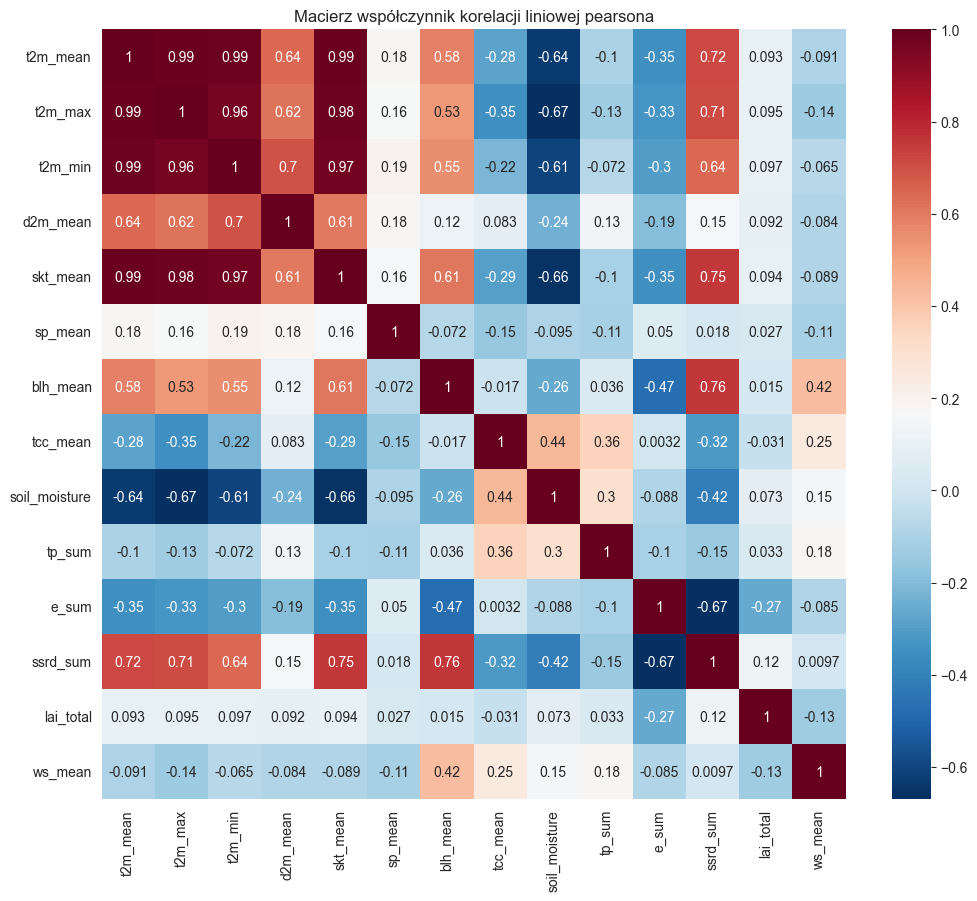

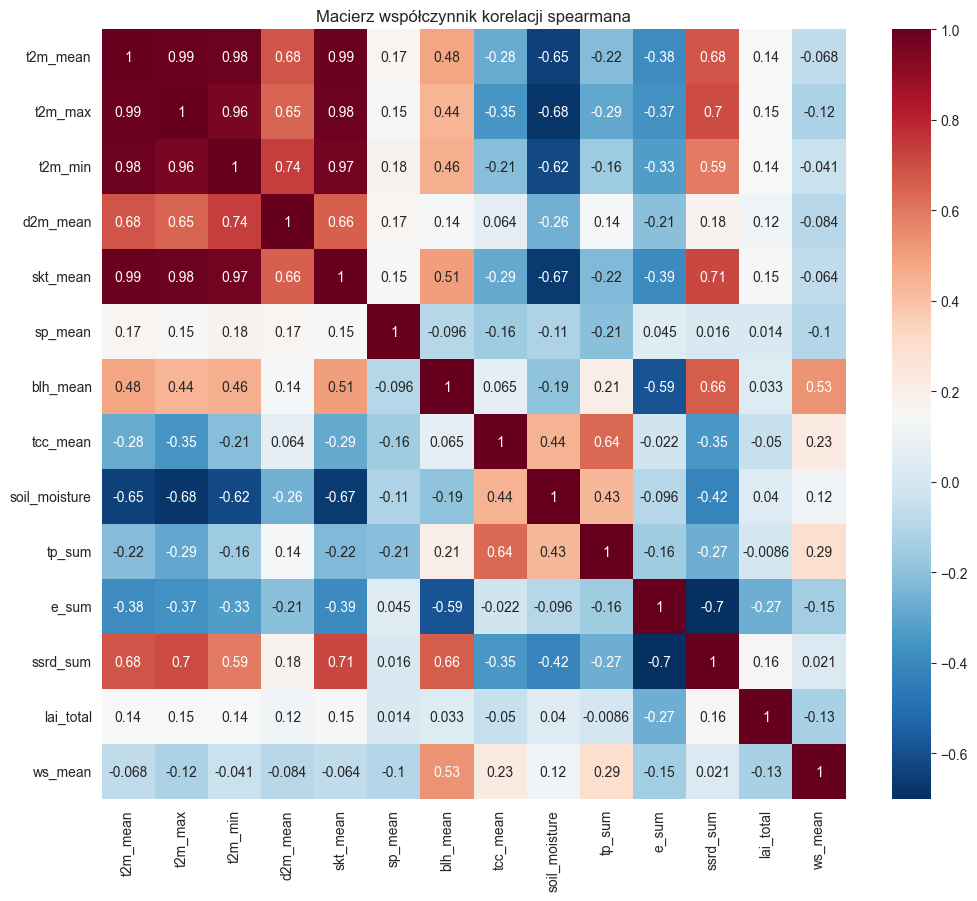

In [43]:
def write_heat_map( methoda ):
    corr_map = df[col_num].corr( method=methoda )
    plt.figure( figsize = ( 12, 10 ) )
    sns.heatmap( corr_map , annot = True, cmap = "RdBu_r")
    if methoda == "pearson":
        plt.title(f"Macierz współczynnik korelacji liniowej {methoda}a")
    elif methoda == "spearman":
        plt.title(f"Macierz współczynnik korelacji {methoda}a")
    plt.show()

write_heat_map("pearson")
write_heat_map("spearman")

# Jak interpretować to
Persona - korelacja
| r | > 0.9 prawie to samo
0.6 - 0.9 - silna zależność
< 0.3 - słaba zależność



# Temperatura analiza

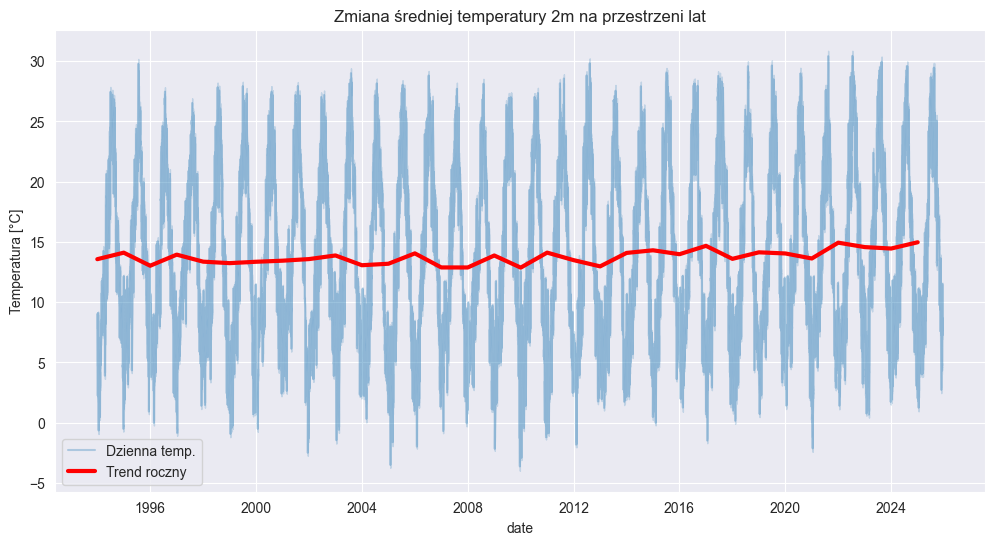

In [35]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='t2m_mean', alpha=0.3, label='Dzienna temp.')
sns.lineplot(data=df_yearly, x=pd.to_datetime(df_yearly['year'], format='%Y'), y='t2m_mean', color='red', linewidth=3, label='Trend roczny')
plt.title('Zmiana średniej temperatury 2m na przestrzeni lat')
plt.ylabel('Temperatura [°C]')
plt.show()

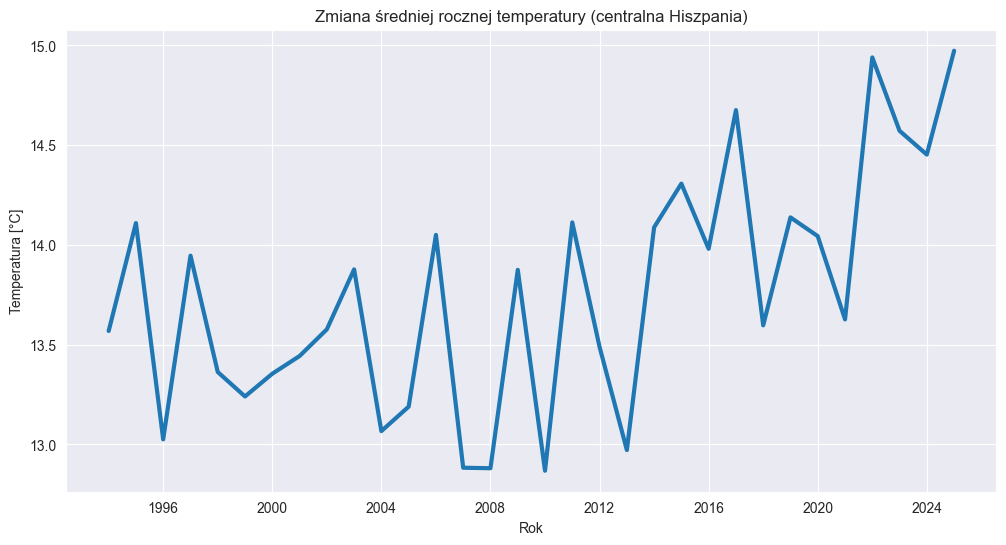

In [25]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_yearly,
    x=pd.to_datetime(df_yearly['year'], format='%Y'),
    y='t2m_mean',
    linewidth=3
)
plt.title('Zmiana średniej rocznej temperatury (centralna Hiszpania)')
plt.ylabel('Temperatura [°C]')
plt.xlabel('Rok')
plt.show()

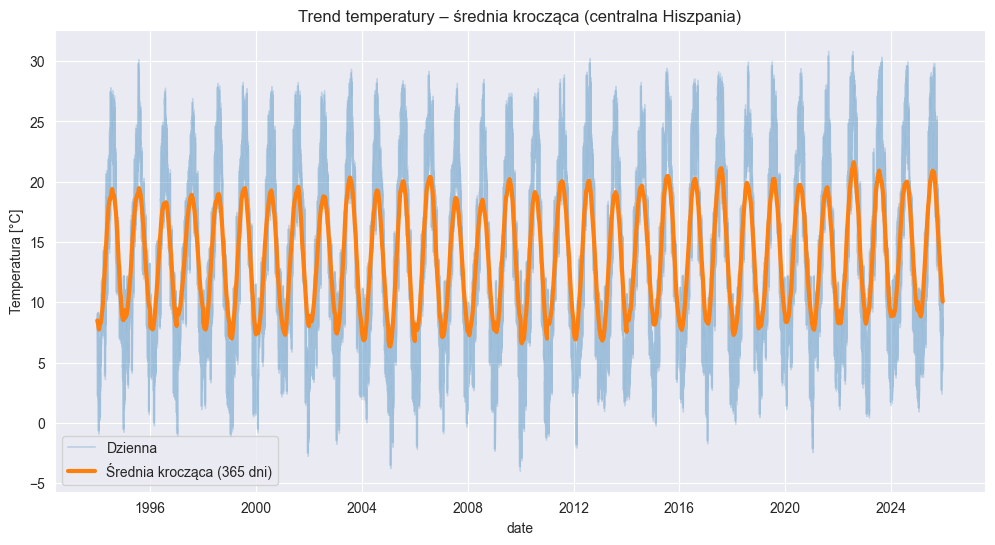

In [26]:
df['t2m_roll_365'] = df['t2m_mean'].rolling(365, center=True).mean()

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='date', y='t2m_mean', alpha=0.2, label='Dzienna')
sns.lineplot(data=df, x='date', y='t2m_roll_365', linewidth=3, label='Średnia krocząca (365 dni)')
plt.title('Trend temperatury – średnia krocząca (centralna Hiszpania)')
plt.ylabel('Temperatura [°C]')
plt.legend()
plt.show()


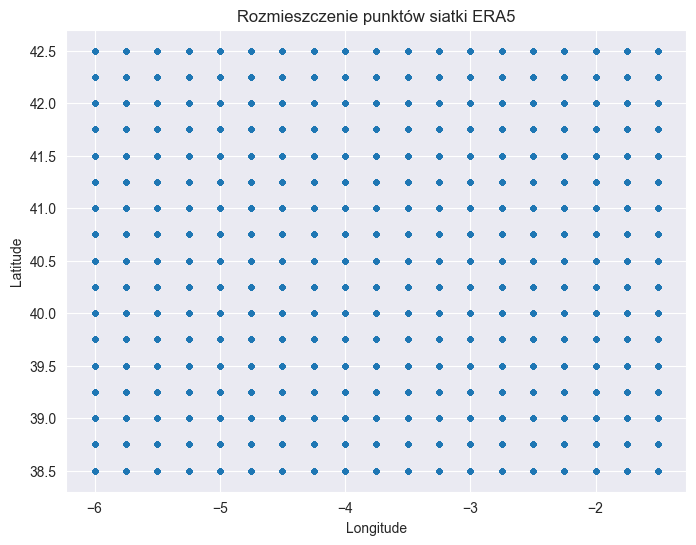

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], s=10, alpha=0.5)
plt.title("Rozmieszczenie punktów siatki ERA5")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [21]:
import plotly.express as px

df_map = (
    df.groupby(['year', 'latitude', 'longitude'])['t2m_mean']
      .mean()
      .reset_index()
)
df_map.head(5)


fig = px.scatter_mapbox(
    df_map,
    lat="latitude",
    lon="longitude",
    color="t2m_mean",
    animation_frame="year",   # <<< SUWAK
    zoom=5,
    mapbox_style="carto-positron",
    title="Średnia temperatura roczna w punktach siatki"
)

fig.show()

C:\Users\oliwi\AppData\Local\Temp\ipykernel_27104\1396500212.py:11: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

